## 2. *Question Answering*

Las redes neuronales recurrentes hoy en día han sido aplicadas a varios problemas que involucra dependencia temporal de los datos de entrada, en textos por lo común, tal como los modelos *sequence to sequence* de traducción, resumir textos, formular hipótesis de un extracto o, como veremos en esta actividad, generar respuesta en base a alguna pregunta. En imágenes también han sido aplicadas, ya sea a procesamiento de videos u a otro problema en que las imágenes tienen dependencia temporal unas con otras.

Para ésta actividad trabajaremos el dataset de __[SQuAD2.0](https://rajpurkar.github.io/SQuAD-explorer/)__  (The Stanford Question Answering Dataset), los datos se los entregamos en formato *csv*, sin ningún preprocesamiento, para que sea mas fácil la lectura. La tarea como ya se comentó consiste en predecir una respuesta (secuencia de palabras) que contesten una pregunta también en forma de secuencia de palabras, con un enfoque *encoder-decoder* con módulos de antención.


<img src="https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2017/07/20/sockeye_1.gif" title="Attention" width="65%" style="float: right;"/>


<img src="http://www.wildml.com/wp-content/uploads/2015/12/Screen-Shot-2015-12-30-at-1.16.08-PM.png" title="Attention" width="35%" style="float: left;"/>



Los módulos de antención [[6]](#refs) son una variación a la arquitectura *encoder-decoder* en donde se agrega que para cada instante de tiempo de la **decodificación** $T'$ hay una combinación lineal del vector de codificación en todos los instantes tiempo $T$, ésto es para que en cada instante de tiempo de la decodificación se ponga atención a cierta información en toda la secuencia de entrada. 


$$
y_{T'} = \sum_{t}^{T} \alpha_{T',t} \cdot h_t^{codificacion}
$$


In [1]:
import pandas as pd

from nltk.tokenize import word_tokenize

> a) Carge los datos y descríbalos ¿Cuántos ejemplos se tienen para entrenar y para predecir?

In [2]:
df_train = pd.read_csv('train_Q-A.csv')
df_train.dropna(inplace=True)
df_test = pd.read_csv('test_Q.csv')
df_train.head()

,id,question,answer
0,56be85543aeaaa14008c9063,When did Beyonce start becoming popular?,in the late 1990s
1,56be85543aeaaa14008c9065,What areas did Beyonce compete in when she was...,singing and dancing
2,56be85543aeaaa14008c9066,When did Beyonce leave Destiny's Child and bec...,2003
3,56bf6b0f3aeaaa14008c9601,In what city and state did Beyonce grow up?,"Houston, Texas"
4,56bf6b0f3aeaaa14008c9602,In which decade did Beyonce become famous?,late 1990s


In [3]:
print("Cantidad de ejemplos de entrenamiento: ", df_train.shape[0])
print("Cantidad de ejemplos de prueba: ", df_test.shape[0])

Cantidad de ejemplos de entrenamiento:  86821
Cantidad de ejemplos de prueba:  11873


In [4]:
df_train.describe()

,id,question,answer
count,86821,86821,86821
unique,86821,86769,64763
top,56e0d561231d4119001ac415,When did Prince Albert die?,three
freq,1,2,231


In [5]:
df_test.describe()

,id,question
count,11873,11873
unique,11873,11864
top,57303048947a6a140053d257,What are the main sources of primary law?
freq,1,2


> b) Realice un preprocesamiento simple a los textos de entrada (preguntas) *tokenizandolos* y pasando a minúsculas para evitar ambiguedad, si desea agregar algun preprocesamiento éxtra ésto se verá reflajado en su nota. A los textos de salida (respuestas) no realice ningún preprocesamiento mas que *tokenizar*, puesto que para la evaluación se solicita retornar los textos en su forma natural. Comente lo realizado.

In [6]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

#preprocesamiento textos de entrada
train_questions = [tokenizer.tokenize(sentence.lower()) for sentence in df_train["question"]]
test_questions = [word_tokenize(sentence.lower()) for sentence in df_test["question"]]

In [7]:
print(train_questions[7])

['who', 'managed', 'the', 'destiny', 's', 'child', 'group']


In [8]:
df_train["question"]

0                 When did Beyonce start becoming popular?
1        What areas did Beyonce compete in when she was...
2        When did Beyonce leave Destiny's Child and bec...
3            In what city and state did Beyonce  grow up? 
4               In which decade did Beyonce become famous?
5               In what R&B group was she the lead singer?
6            What album made her a worldwide known artist?
7                   Who managed the Destiny's Child group?
8                           When did Beyoncé rise to fame?
9           What role did Beyoncé have in Destiny's Child?
10       What was the first album Beyoncé released as a...
11           When did Beyoncé release Dangerously in Love?
12       How many Grammy awards did Beyoncé win for her...
13             What was Beyoncé's role in Destiny's Child?
14        What was the name of Beyoncé's first solo album?
15       After her second solo album, what other entert...
16                         Which artist did Beyonce marr

In [9]:
train_answers = [word_tokenize(sentence) for sentence in df_train["answer"]]

In [10]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# lemmas para train y test
for q in range(len(train_questions)):
    train_questions[q] = [WordNetLemmatizer().lemmatize(w) for w in train_questions[q]]
for q in range(len(test_questions)):
    test_questions[q] = [WordNetLemmatizer().lemmatize(w) for w in test_questions[q]]

In [11]:
train_questions

[['when', 'did', 'beyonce', 'start', 'becoming', 'popular'],
 ['what',
  'area',
  'did',
  'beyonce',
  'compete',
  'in',
  'when',
  'she',
  'wa',
  'growing',
  'up'],
 ['when',
  'did',
  'beyonce',
  'leave',
  'destiny',
  's',
  'child',
  'and',
  'become',
  'a',
  'solo',
  'singer'],
 ['in', 'what', 'city', 'and', 'state', 'did', 'beyonce', 'grow', 'up'],
 ['in', 'which', 'decade', 'did', 'beyonce', 'become', 'famous'],
 ['in', 'what', 'r', 'b', 'group', 'wa', 'she', 'the', 'lead', 'singer'],
 ['what', 'album', 'made', 'her', 'a', 'worldwide', 'known', 'artist'],
 ['who', 'managed', 'the', 'destiny', 's', 'child', 'group'],
 ['when', 'did', 'beyoncé', 'rise', 'to', 'fame'],
 ['what', 'role', 'did', 'beyoncé', 'have', 'in', 'destiny', 's', 'child'],
 ['what',
  'wa',
  'the',
  'first',
  'album',
  'beyoncé',
  'released',
  'a',
  'a',
  'solo',
  'artist'],
 ['when', 'did', 'beyoncé', 'release', 'dangerously', 'in', 'love'],
 ['how',
  'many',
  'grammy',
  'award',
  'd

> c) Cree un vocabulario para codificar las palabras en las respuestas a generar. Repita el procedimiento para las preguntas. Agrege un símbolo que signifique el fin de la respuesta a generar, así para tener un criterio de cuando una respuesta, valga la redundancia, está efectivamente *respondida* ¿Cuántas palabras tiene el vocabulario de las respuestas y de las preguntas? ¿Ésto podría ser un problema al momento de entrenar la red para que predizca de entre todas ellas?

In [12]:
vocab_answer = set()
for sentence in train_answers:
    for word in sentence:
        vocab_answer.add(word)
vocab_answer = ["#end"]+ list(vocab_answer)
print('posibles palabras para respuestas :', len(vocab_answer))
vocabA_indices = {c: i for i, c in enumerate(vocab_answer)}
indices_vocabA = {i: c for i, c in enumerate(vocab_answer)}

posibles palabras para respuestas : 47423


In [13]:
#sameforquestions
vocab_question = set()
for sentence in train_questions+test_questions:
    for word in sentence:
        vocab_question.add(word)
vocab_question = list(vocab_question)
print('posibles palabras para preguntas :', len(vocab_question))
vocabQ_indices = {c: i for i, c in enumerate(vocab_question)}


posibles palabras para preguntas : 35201


d) Codifique los tokens (palabras) de cada texto que utilizará.

In [14]:
#input and output to onehotvector
X_answers = [[vocabA_indices[palabra] for palabra in sentence] for sentence in train_answers]
Xtrain_question = [[vocabQ_indices[word] for word in sentence] for sentence in train_questions]
Xtest_question = [[vocabQ_indices[word] for word in sentence] for sentence in test_questions]

Luego de ésto realice un padding a ambas secuencias, entrada y salida de entrenamiento y a la entrada del conjunto de pruebas. Comente sobre las dimensionalidades finales de los conjuntos de entrenamiento y de prueba.

In [21]:
import numpy as np
max_input_lenght = np.max(list(map(len,train_questions)))
max_output_lenght = np.max(list(map(len,train_answers)))+1
print("Max largo pregunta: {}\nMax largo respuesta: {}".format(max_input_lenght, max_output_lenght))

from keras.preprocessing import sequence
Xtrain_question = sequence.pad_sequences(Xtrain_question,maxlen=max_input_lenght,padding='post',value=0)
Xtest_question = sequence.pad_sequences(Xtest_question,maxlen=max_input_lenght,padding='post',value=0)
X_answers = sequence.pad_sequences(X_answers,maxlen=max_output_lenght,padding='post',value=vocabA_indices["#end"])

Max largo pregunta: 40
Max largo respuesta: 47


/home/fefi/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [35]:
print("Dimensiones Xtrain: {}".format(Xtrain_question.shape))
print("Dimensiones Xtest: {}".format(Xtest_question.shape))
print("Dimensiones Output: {}".format(X_answers.shape))

Dimensiones Xtrain: (86821, 40)
Dimensiones Xtest: (11873, 40)
Dimensiones Output: (86821, 47)


In [36]:
X_answers  = X_answers.reshape(X_answers.shape[0],X_answers.shape[1],1)
print("Nueva dimensión salida: {}".format(X_answers.shape))

Nueva dimensión salida: (86821, 47, 1)


e) Defina el modelo encoder-decoder con los módulos de atención.

In [45]:
#Encoder-Decoder modelo
from keras.layers import Input,RepeatVector,TimeDistributed,Dense,Embedding,Flatten,Activation,Permute,Lambda, CuDNNLSTM
from keras.models import Model
from keras import backend as K
lenght_output = max_output_lenght
hidden_dim = 128

Defina el encoder y las compuertas que utilizará: CuDNNGRU,CuDNNLSTM, RNN u otra. Puede utilizar redes bidireccionales en el encoder ¿Esto mejora el resultado?

In [46]:
# probar con otras compuertas
embedding_vector = 64 
encoder_input = Input(shape=(max_input_lenght,))
embedded = Embedding(input_dim=len(vocabQ_indices),output_dim=embedding_vector,input_length=max_input_lenght)(encoder_input)
encoder = CuDNNLSTM(hidden_dim, return_sequences=True)(embedded)

Defina la atención $\alpha$ que se calculará sobre cada instante de tiempo $T$ computándo su atención en cada instante de tiempo de la decodificación $T'$.

In [47]:
# compute T' importance for each step T
attention = TimeDistributed(Dense(max_output_lenght, activation='tanh'))(encoder)
#softmax a las antenciones sobre todo T
attention = Permute([2, 1])(attention)
attention = Activation('softmax')(attention) 
attention = Permute([2, 1])(attention)

Aplique la atención sobre el encoder y genere las salidas correspondientes.

In [48]:
# apply the attention to encoder
def attention_multiply(vects):
    encoder, attention = vects
    return K.batch_dot(attention,encoder, axes=1)
sent_representation = Lambda(attention_multiply)([encoder, attention])
decoder = CuDNNLSTM(hidden_dim, return_sequences=True)(sent_representation)
probabilities = TimeDistributed(Dense(len(vocab_answer), activation="softmax"))(decoder)

Defina el modelo y descríbalo adecuadamente.

In [49]:
model = Model(encoder_input,probabilities)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 40, 64)       2252864     input_3[0][0]                    
__________________________________________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)        (None, 40, 128)      99328       embedding_3[0][0]                
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 40, 47)       6063        cu_dnnlstm_1[0][0]               
__________________________________________________________________________________________________
permute_3 

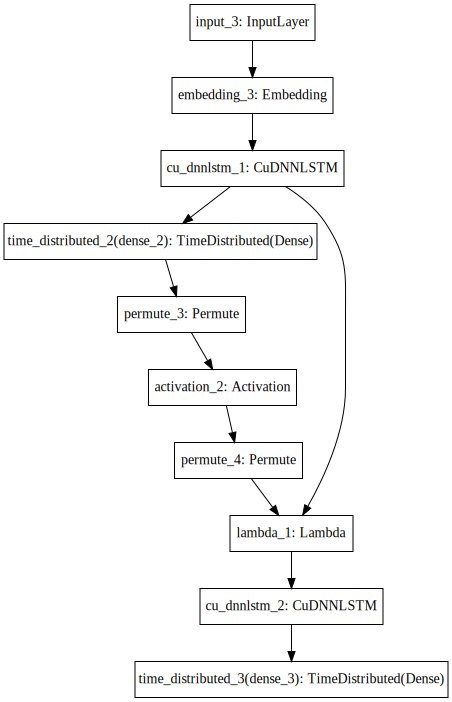

In [50]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

f) Entrene el modelo por 10 epochs con el tamaño de batch que estime conveniente. Para ésto deberá redimensionar la salida para que tenga 3 dimensiones debido a la recurrencia.

In [51]:
#X_answers = X_answers.reshape(X_answers.shape[0],X_answers.shape[1],1)
#X_answers.shape
model.fit(Xtrain_question,X_answers,epochs=1,batch_size=128,validation_split=0.2)

Train on 69456 samples, validate on 17365 samples
Epoch 1/1


InvalidArgumentError: No OpKernel was registered to support Op 'CudnnRNN' with these attrs.  Registered devices: [CPU], Registered kernels:
  <no registered kernels>

	 [[Node: cu_dnnlstm_1/CudnnRNN = CudnnRNN[T=DT_FLOAT, direction="unidirectional", dropout=0, input_mode="linear_input", is_training=true, rnn_mode="lstm", seed=87654321, seed2=0](cu_dnnlstm_1/transpose, cu_dnnlstm_1/ExpandDims_1, cu_dnnlstm_1/ExpandDims_2, cu_dnnlstm_1/concat_1)]]

Caused by op 'cu_dnnlstm_1/CudnnRNN', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 281, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 232, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 397, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-46-0d9e28fd6f78>", line 5, in <module>
    encoder = CuDNNLSTM(hidden_dim, return_sequences=True)(embedded)
  File "/home/fefi/tensorflow/lib/python3.5/site-packages/keras/layers/recurrent.py", line 499, in __call__
    return super(RNN, self).__call__(inputs, **kwargs)
  File "/home/fefi/tensorflow/lib/python3.5/site-packages/keras/engine/topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/fefi/tensorflow/lib/python3.5/site-packages/keras/layers/cudnn_recurrent.py", line 90, in call
    output, states = self._process_batch(inputs, initial_state)
  File "/home/fefi/tensorflow/lib/python3.5/site-packages/keras/layers/cudnn_recurrent.py", line 510, in _process_batch
    is_training=True)
  File "/home/fefi/tensorflow/lib/python3.5/site-packages/tensorflow/contrib/cudnn_rnn/python/ops/cudnn_rnn_ops.py", line 1443, in __call__
    input_data, input_h, input_c, params, is_training=is_training)
  File "/home/fefi/tensorflow/lib/python3.5/site-packages/tensorflow/contrib/cudnn_rnn/python/ops/cudnn_rnn_ops.py", line 1334, in __call__
    seed=self._seed)
  File "/home/fefi/tensorflow/lib/python3.5/site-packages/tensorflow/contrib/cudnn_rnn/python/ops/cudnn_rnn_ops.py", line 823, in _cudnn_rnn
    name=name)
  File "/home/fefi/tensorflow/lib/python3.5/site-packages/tensorflow/contrib/cudnn_rnn/ops/gen_cudnn_rnn_ops.py", line 105, in cudnn_rnn
    is_training=is_training, name=name)
  File "/home/fefi/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/fefi/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/fefi/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): No OpKernel was registered to support Op 'CudnnRNN' with these attrs.  Registered devices: [CPU], Registered kernels:
  <no registered kernels>

	 [[Node: cu_dnnlstm_1/CudnnRNN = CudnnRNN[T=DT_FLOAT, direction="unidirectional", dropout=0, input_mode="linear_input", is_training=true, rnn_mode="lstm", seed=87654321, seed2=0](cu_dnnlstm_1/transpose, cu_dnnlstm_1/ExpandDims_1, cu_dnnlstm_1/ExpandDims_2, cu_dnnlstm_1/concat_1)]]
